<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/03_Evaluate_1B_CARBON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Evaluation
## 03 - Measuring Environmental Impact & Inference Performance

### Exploring energy efficiency of width-pruned GLU models
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** GPU L4 (or T4)

**Models to Profile:**
- Llama-3.2-1B (baseline)
- Llama-3.2-1B-pruned-40%

**Workloads (2 representative):**
- GSM8K: Math reasoning (100 prompts, 100 max tokens)
- MMLU: Knowledge QA (100 prompts, 50 max tokens)

**Metrics Collected:**
- Energy consumption (kWh via CodeCarbon)
- Throughput (tokens/second)
- Latency (TTFT - Time To First Token)
- Memory footprint (GPU allocation)

**Estimated Runtime:** ~1-2 hours total

---

## 📋 Notebook Objective

This notebook conducts a comprehensive evaluation of the Llama-3.2-1B model family across three pruning levels (20%, 40%, 60%) to determine:

1. **Performance degradation patterns** across different pruning intensities
2. **Optimal expansion ratio** for GLU-MLP layers (hypothesis: 140%)
3. **Task-specific resilience** to pruning (knowledge vs. algorithmic tasks)
4. **Which models merit uploading to HuggingFace Hub** for Phase 2

### Key Features:
- ✅ **Checkpoint/Resume Support:** Survives Colab disconnections
- ✅ **On-the-fly Pruning:** No need to pre-create models
- ✅ **Robust Error Handling:** Continues if individual benchmarks fail
- ✅ **Progress Tracking:** Live updates and detailed logging

### Results will answer:
- Does 40% pruning (140% expansion) truly outperform other levels?
- Which benchmarks are most sensitive to pruning?
- Should we upload non-star models to HF, or only the 40% version?

---

**Note:** This evaluation uses the MAW (Maximum Absolute Weight) neuron selection method, validated in Notebook 00 as the optimal approach for GLU architectures.

---

# 1. Setup & Installation

In [1]:
# Install required libraries
!pip install -q optipfair
!pip install -q lm-eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 62.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Mount Google Drive for checkpoint persistence
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

✅ utils.py downloaded successfully


In [4]:
# Import core libraries and utilities
import torch
import json
import pandas as pd
from datetime import datetime
from pathlib import Path
import glob

# Import our utility functions
from utils import (
    EXPERIMENT_CONFIG_CARBON,
    BENCHMARKS_CARBON,
    load_or_create_model,
    run_carbon_profiling,
    run_robust_evaluation,
    clear_gpu_cache,
    get_model_stats,
    format_results_table,
    calibrate_idle_power  # ← NUEVA FUNCIÓN
)

print("✅ All imports successful")
print(f"📱 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful
📱 Device: GPU
   GPU: NVIDIA L4
   Memory: 23.8 GB


# 2. Configuration & Planning

This section filters the experiment configuration for 1B models and displays the profiling plan.

In [5]:
# Filter configuration for 1B models only
models_1b = [
    config for config in EXPERIMENT_CONFIG_CARBON
    if "1B" in config["base_model"] and "3B" not in config["base_model"] and "Instruct" not in config["base_model"]
]

print(f"\n{'='*70}")
print("📊 EVALUATION PLAN: Llama-3.2-1B Family")
print(f"{'='*70}\n")

print(f"Total models to evaluate: {len(models_1b) + 1}")  # +1 for base model
print(f"Benchmarks per model: {len(BENCHMARKS_CARBON)}")
print(f"Total evaluations: {(len(models_1b) + 1) * len(BENCHMARKS_CARBON)}")
print(f"Estimated runtime: ~1-1.5 hours\n")

# Display models table
print("Models to profile:")
print("-" * 70)
print(f"{'Model':<40} {'Pruning':<10} {'Star':<6}")
print("-" * 70)

for config in models_1b:
    if config['pruning_pct'] == 0:
        model_name = "Llama-3.2-1B (baseline)"
    else:
        model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"

    pruning = f"{config['pruning_pct']}%"
    star = "⭐ Yes" if config['is_star'] else "No"
    print(f"{model_name:<40} {pruning:<10} {star:<6}")

print("-" * 70)

# Display workloads
print("\nWorkloads to run:")
print("-" * 70)
for i, workload in enumerate(BENCHMARKS_CARBON, 1):
    name = workload['name']
    prompts = workload['num_prompts']
    tokens = workload['max_new_tokens']
    desc = workload['description']
    print(f"{i}. {name:<25} {prompts} prompts, {tokens} tokens - {desc}")
print("-" * 70)

print("\n⚙️ Configuration:")
print(f"   - Neuron selection method: MAW (Maximum Absolute Weight)")
print(f"   - Checkpointing: Enabled (per-workload granularity)")
print(f"   - Model creation: On-the-fly pruning (no pre-creation needed)")
print(f"   - GPU warm-up: First 5 prompts excluded from metrics")
print(f"   - Energy tracking: CodeCarbon")


📊 EVALUATION PLAN: Llama-3.2-1B Family

Total models to evaluate: 3
Benchmarks per model: 6
Total evaluations: 18
Estimated runtime: ~1-1.5 hours

Models to profile:
----------------------------------------------------------------------
Model                                    Pruning    Star  
----------------------------------------------------------------------
Llama-3.2-1B (baseline)                  0%         No    
Llama-3.2-1B-pruned-40%                  40%        ⭐ Yes 
----------------------------------------------------------------------

Workloads to run:
----------------------------------------------------------------------
1. gsm8k_latency_b1          10 prompts, 100 tokens - Math reasoning (Latency, TTFT, bsz=1)
2. mmlu_latency_b1           10 prompts, 50 tokens - Knowledge QA (Latency, TTFT, bsz=1)
3. ifeval_latency_b1         10 prompts, 150 tokens - Instruction (Latency, TTFT, bsz=1)
4. gsm8k_throughput_b8       10 prompts, 100 tokens - Math reasoning (Throughput, b

In [6]:
# Setup checkpoint paths (manual construction since helpers are internal)
BASE_CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints"
RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

# Carbon-specific subdirectory
CHECKPOINT_DIR = f"{BASE_CHECKPOINT_DIR}/1b_carbon"

# Create directories if they don't exist
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print(f"✅ Checkpoint directory: {CHECKPOINT_DIR}")
print(f"✅ Results directory: {RESULTS_DIR}")

# ============================================================================
# CONSTRUCT CHECKPOINT PATHS DYNAMICALLY FROM models_1b
# ============================================================================
checkpoint_paths = {}

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Create key: "baseline" for 0%, "{X}pct" for others
    if pruning_pct == 0:
        key = "baseline"
        filename = "llama_3.2_1b_baseline_carbon.json"
    else:
        key = f"{pruning_pct}pct"
        filename = f"llama_3.2_1b_pruned_{pruning_pct}pct_carbon.json"

    checkpoint_paths[key] = f"{CHECKPOINT_DIR}/{filename}"

print(f"\n📂 Auto-generated {len(checkpoint_paths)} checkpoint paths:")
for key, path in checkpoint_paths.items():
    exists = "✅ Exists" if Path(path).exists() else "🆕 New"
    print(f"  {key:<10}: {exists}")

✅ Checkpoint directory: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon
✅ Results directory: /content/drive/MyDrive/glu_pruning/results

📂 Auto-generated 2 checkpoint paths:
  baseline  : ✅ Exists
  40pct     : ✅ Exists


# 3. Baseline Evaluation

Evaluate the original Llama-3.2-1B model to establish performance baseline.

In [7]:
# ====================================================================
# CALIBRATE IDLE POWER (Run once at start)
# ====================================================================
print("="*70)
print("🔋 STEP 0: IDLE POWER CALIBRATION")
print("="*70 + "\n")

idle_calibration = calibrate_idle_power(
    device="cuda",
    duration_seconds=30,  # 30s is enough for stable measurement
    verbose=True
)

# Save calibration to drive for reproducibility
calibration_path = f"{RESULTS_DIR}/idle_power_calibration.json"
with open(calibration_path, 'w') as f:
    json.dump(idle_calibration, f, indent=2)

print(f"\n💾 Calibration saved to: {calibration_path}")
print("="*70 + "\n")

[codecarbon WARNING @ 23:00:11] Multiple instances of codecarbon are allowed to run at the same time.


🔋 STEP 0: IDLE POWER CALIBRATION

🔋 Starting idle power calibration (30s)...
   Clearing GPU cache...
   Measuring idle power for 30s...
✅ Calibration complete!
   Idle Power: 42.38 W
   Idle Energy (30s): 0.000353 kWh
   GPU Temperature: 44.0°C

💾 Calibration saved to: /content/drive/MyDrive/glu_pruning/results/idle_power_calibration.json



In [ ]:
print(f"\n{'='*70}")
print("📊 PHASE 1: BASELINE PROFILING")
print(f"{'='*70}\n")


BASE_MODEL_ID = "meta-llama/Llama-3.2-1B"

# Load base model
from transformers import AutoModelForCausalLM, AutoTokenizer

print(f"Loading base model: {BASE_MODEL_ID}...")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=torch.bfloat16,  # Use bfloat16 for A100, float16 for T4
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Model loaded successfully")

# Display model statistics
base_stats = get_model_stats(base_model)
print(f"\n📈 Model Statistics:")
print(f"   Parameters: {base_stats['total_parameters']:,}")
print(f"   Size: {base_stats['size_gb']:.2f} GB")

# Run carbon profiling with checkpointing
baseline_results = run_carbon_profiling(
    model=base_model,
    tokenizer=tokenizer,
    workloads=BENCHMARKS_CARBON,
    checkpoint_path=checkpoint_paths["baseline"],
    model_name="Llama-3.2-1B-baseline",
    idle_power_calibration=idle_calibration,
    device="cuda"
)

print(f"\n{'='*70}")
print("✅ BASELINE PROFILING COMPLETED")
print(f"{'='*70}\n")

# Display results summary
print("Results Summary:")
for workload_name, metrics in baseline_results.items():
    print(f"\n{workload_name}:")
    print(f"  Energy: {metrics['energy_kwh']:.6f} kWh")
    print(f"  Throughput: {metrics['throughput_tokens_per_sec']:.2f} tok/s")
    if metrics['avg_ttft_ms'] is not None:
        print(f"  Avg TTFT: {metrics['avg_ttft_ms']:.2f} ms")
    else:
        print(f"  Avg TTFT: N/A (throughput mode)")
    print(f"  Memory: {metrics['model_size_gb']:.2f} GB")

# Clear memory
del base_model
clear_gpu_cache()
print("\n🧹 Memory cleared, ready for pruned models")

# 4. Pruned Models Evaluation Loop

Profile the pruned variants using on-the-fly pruning with OptiPFair.

In [ ]:
print(f"\n{'='*70}")
print("📊 PHASE 2: PRUNED MODELS PROFILING")
print(f"{'='*70}\n")

# Store all results for final comparison
all_results = {
    "baseline": baseline_results
}


# Filter out baseline (already done)
pruned_models = [m for m in models_1b if m['pruning_pct'] > 0]

# Evaluate each pruned model
for i, config in enumerate(pruned_models, 1):
    model_name = f"Llama-3.2-1B-pruned-{config['pruning_pct']}%"
    pruning_pct = config['pruning_pct']
    is_star = config['is_star']

    print(f"\n{'─'*70}")
    print(f"🔄 PROFILING MODEL {i}/{len(pruned_models)}: {model_name}")
    print(f"   Pruning: {pruning_pct}% | Star: {'⭐' if is_star else 'No'}")
    print(f"{'─'*70}\n")

    try:
        # Load or create model using utility function
        model, tokenizer, stats = load_or_create_model(config, device="auto")

        # Display model statistics
        print(f"\n📈 Model Statistics:")
        print(f"   Parameters: {stats['total_parameters']:,}")
        print(f"   Size: {stats['size_gb']:.2f} GB")
        if 'pruning_stats' in stats:
            print(f"   Reduction: {stats['pruning_stats']['percentage_reduction']:.2f}%")
        print(f"   Source: {stats['source']}\n")

        # Determine checkpoint key
        checkpoint_key = f"{pruning_pct}pct"

        # Run profiling with checkpointing
        results = run_carbon_profiling(
            model=model,
            tokenizer=tokenizer,
            workloads=BENCHMARKS_CARBON,
            checkpoint_path=checkpoint_paths[checkpoint_key],
            model_name=model_name,
            idle_power_calibration=idle_calibration,
            device="cuda"
        )

        # Store results
        all_results[checkpoint_key] = results

        print(f"\n✅ {model_name} profiling completed")

        # Display results summary
        print("\nResults Summary:")
        for workload_name, metrics in results.items():
            print(f"\n{workload_name}:")
            print(f"  Energy: {metrics['energy_kwh']:.6f} kWh")
            print(f"  Throughput: {metrics['throughput_tokens_per_sec']:.2f} tok/s")
            if metrics['avg_ttft_ms'] is not None:
                print(f"  Avg TTFT: {metrics['avg_ttft_ms']:.2f} ms")
            else:
                print(f"  Avg TTFT: N/A (throughput mode)")
            print(f"  Memory: {metrics['model_size_gb']:.2f} GB")

        # Clear memory before next model
        del model
        clear_gpu_cache()

    except Exception as e:
        print(f"\n❌ ERROR profiling {model_name}: {str(e)}")
        print("   Continuing with next model...\n")
        clear_gpu_cache()
        continue

print(f"\n{'='*70}")
print("✅ ALL MODELS PROFILED")
print(f"{'='*70}\n")

# 5. Results Consolidation & Export

Consolidate all evaluation results and export to CSV for analysis.

In [10]:
print(f"\n{'='*70}")
print("📊 CONSOLIDATING CARBON PROFILING RESULTS")
print(f"{'='*70}\n")

# ============================================================================
# BUILD DYNAMIC MAPPINGS FROM models_1b
# ============================================================================
model_names = {}
model_pruning = {}
model_is_star = {}

for config in models_1b:
    pruning_pct = config['pruning_pct']

    # Create key
    key = "baseline" if pruning_pct == 0 else f"{pruning_pct}pct"

    # Build mappings
    if pruning_pct == 0:
        model_names[key] = "Llama-3.2-1B"
    else:
        model_names[key] = f"Llama-3.2-1B-pruned-{pruning_pct}%"

    model_pruning[key] = pruning_pct
    model_is_star[key] = config['is_star']

print(f"✅ Auto-generated mappings for {len(model_names)} models")

# ============================================================================
# CONSOLIDATE RESULTS
# ============================================================================
consolidated_data = []

# Process each model's results
for model_key, workload_results in all_results.items():
    display_name = model_names.get(model_key, model_key)
    pruning_pct = model_pruning.get(model_key, 0)
    is_star = model_is_star.get(model_key, False)

    for workload_name, metrics in workload_results.items():
        row = {
            "model": display_name,
            "pruning_pct": pruning_pct,
            "is_star": is_star,
            "workload": workload_name,
            **metrics  # Unpack all metrics
        }
        consolidated_data.append(row)

# Create DataFrame
df = pd.DataFrame(consolidated_data)

# Sort by pruning_pct and workload
df = df.sort_values(by=["pruning_pct", "workload"]).reset_index(drop=True)

print(f"✅ Consolidated {len(df)} result rows")
print(f"   Models: {df['model'].nunique()}")
print(f"   Workloads: {df['workload'].nunique()}")

# Display preview
print("\nDataFrame Preview:")
print(df[['model', 'workload', 'energy_kwh', 'throughput_tokens_per_sec', 'avg_ttft_ms', 'model_size_gb']].head(10))

# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"{RESULTS_DIR}/carbon_1b_results_{timestamp}.csv"
df.to_csv(csv_path, index=False)
print(f"\n💾 Results saved to: {csv_path}")

# Also save a "latest" version
latest_path = f"{RESULTS_DIR}/carbon_1b_results_latest.csv"
df.to_csv(latest_path, index=False)
print(f"💾 Latest results: {latest_path}")

print(f"\n{'='*70}")
print("✅ PROFILING COMPLETE - ALL RESULTS SAVED")
print(f"{'='*70}\n")


📊 CONSOLIDATING CARBON PROFILING RESULTS

✅ Auto-generated mappings for 2 models
✅ Consolidated 12 result rows
   Models: 2
   Workloads: 6

DataFrame Preview:
                     model              workload  energy_kwh  \
0             Llama-3.2-1B      gsm8k_latency_b1    0.000058   
1             Llama-3.2-1B   gsm8k_throughput_b8    0.000022   
2             Llama-3.2-1B     ifeval_latency_b1    0.000061   
3             Llama-3.2-1B  ifeval_throughput_b8    0.000031   
4             Llama-3.2-1B       mmlu_latency_b1    0.000047   
5             Llama-3.2-1B    mmlu_throughput_b8    0.000011   
6  Llama-3.2-1B-pruned-40%      gsm8k_latency_b1    0.000050   
7  Llama-3.2-1B-pruned-40%   gsm8k_throughput_b8    0.000018   
8  Llama-3.2-1B-pruned-40%     ifeval_latency_b1    0.000087   
9  Llama-3.2-1B-pruned-40%  ifeval_throughput_b8    0.000025   

   throughput_tokens_per_sec  avg_ttft_ms  model_size_gb  
0                  51.312386  1439.710885       2.301884  
1               

In [11]:
print(f"\n{'='*70}")
print("📈 CARBON & PERFORMANCE ANALYSIS")
print(f"{'='*70}\n")

# Calculate averages per model across workloads
summary_data = []

# Use dynamic keys from all_results
for model_key in all_results.keys():
    workload_results = all_results[model_key]

    # Aggregate metrics across workloads
    total_energy = sum(m['energy_kwh'] for m in workload_results.values())
    avg_throughput = sum(m['throughput_tokens_per_sec'] for m in workload_results.values()) / len(workload_results)
    ttft_values = [m['avg_ttft_ms'] for m in workload_results.values() if m['avg_ttft_ms'] is not None]
    avg_ttft = sum(ttft_values) / len(ttft_values) if ttft_values else 0
    model_size = list(workload_results.values())[0]['model_size_gb']  # Same for all workloads

    summary = {
        "model": model_names.get(model_key, model_key),
        "pruning_pct": model_pruning.get(model_key, 0),
        "is_star": model_is_star.get(model_key, False),
        "total_energy_kwh": total_energy,
        "avg_throughput_tok_s": avg_throughput,
        "avg_ttft_ms": avg_ttft,
        "model_size_gb": model_size
    }
    summary_data.append(summary)

# Sort by pruning_pct for consistent display
summary_df = pd.DataFrame(summary_data).sort_values('pruning_pct').reset_index(drop=True)

print("Performance Summary:")
print("-" * 90)
print(summary_df.to_string(index=False, float_format="%.4f"))
print("-" * 90)

# Calculate improvements vs baseline
baseline_row = summary_df[summary_df['pruning_pct'] == 0].iloc[0]

print(f"\n💡 Improvements vs. Baseline:")
print("-" * 90)

for _, row in summary_df.iterrows():
    if row['pruning_pct'] == 0:
        continue

    energy_reduction = ((baseline_row['total_energy_kwh'] - row['total_energy_kwh']) / baseline_row['total_energy_kwh']) * 100
    throughput_change = ((row['avg_throughput_tok_s'] - baseline_row['avg_throughput_tok_s']) / baseline_row['avg_throughput_tok_s']) * 100
    ttft_change = ((row['avg_ttft_ms'] - baseline_row['avg_ttft_ms']) / baseline_row['avg_ttft_ms']) * 100
    size_reduction = ((baseline_row['model_size_gb'] - row['model_size_gb']) / baseline_row['model_size_gb']) * 100

    star_marker = "⭐" if row['is_star'] else ""
    print(f"\n{row['model']} {star_marker}")
    print(f"  Energy: {energy_reduction:+.2f}% ({'✅ Lower' if energy_reduction > 0 else '❌ Higher'})")
    print(f"  Throughput: {throughput_change:+.2f}% ({'✅ Faster' if throughput_change > 0 else '⚠️ Slower'})")
    print(f"  Latency (TTFT): {ttft_change:+.2f}% ({'✅ Lower' if ttft_change < 0 else '⚠️ Higher'})")
    print(f"  Model Size: {size_reduction:+.2f}% ({'✅ Smaller' if size_reduction > 0 else '❌ Larger'})")

print("\n" + "-" * 90)


📈 CARBON & PERFORMANCE ANALYSIS

Performance Summary:
------------------------------------------------------------------------------------------
                  model  pruning_pct  is_star  total_energy_kwh  avg_throughput_tok_s  avg_ttft_ms  model_size_gb
           Llama-3.2-1B            0    False            0.0002               63.0780    1213.7640         2.3019
Llama-3.2-1B-pruned-40%           40     True            0.0002               62.9518    1501.9169         1.7020
------------------------------------------------------------------------------------------

💡 Improvements vs. Baseline:
------------------------------------------------------------------------------------------

Llama-3.2-1B-pruned-40% ⭐
  Energy: +4.10% (✅ Lower)
  Throughput: -0.20% (⚠️ Slower)
  Latency (TTFT): +23.74% (⚠️ Higher)
  Model Size: +26.06% (✅ Smaller)

------------------------------------------------------------------------------------------


# 6. Quick Analysis & Visualization

Generate quick insights to decide which models merit uploading to HuggingFace Hub.

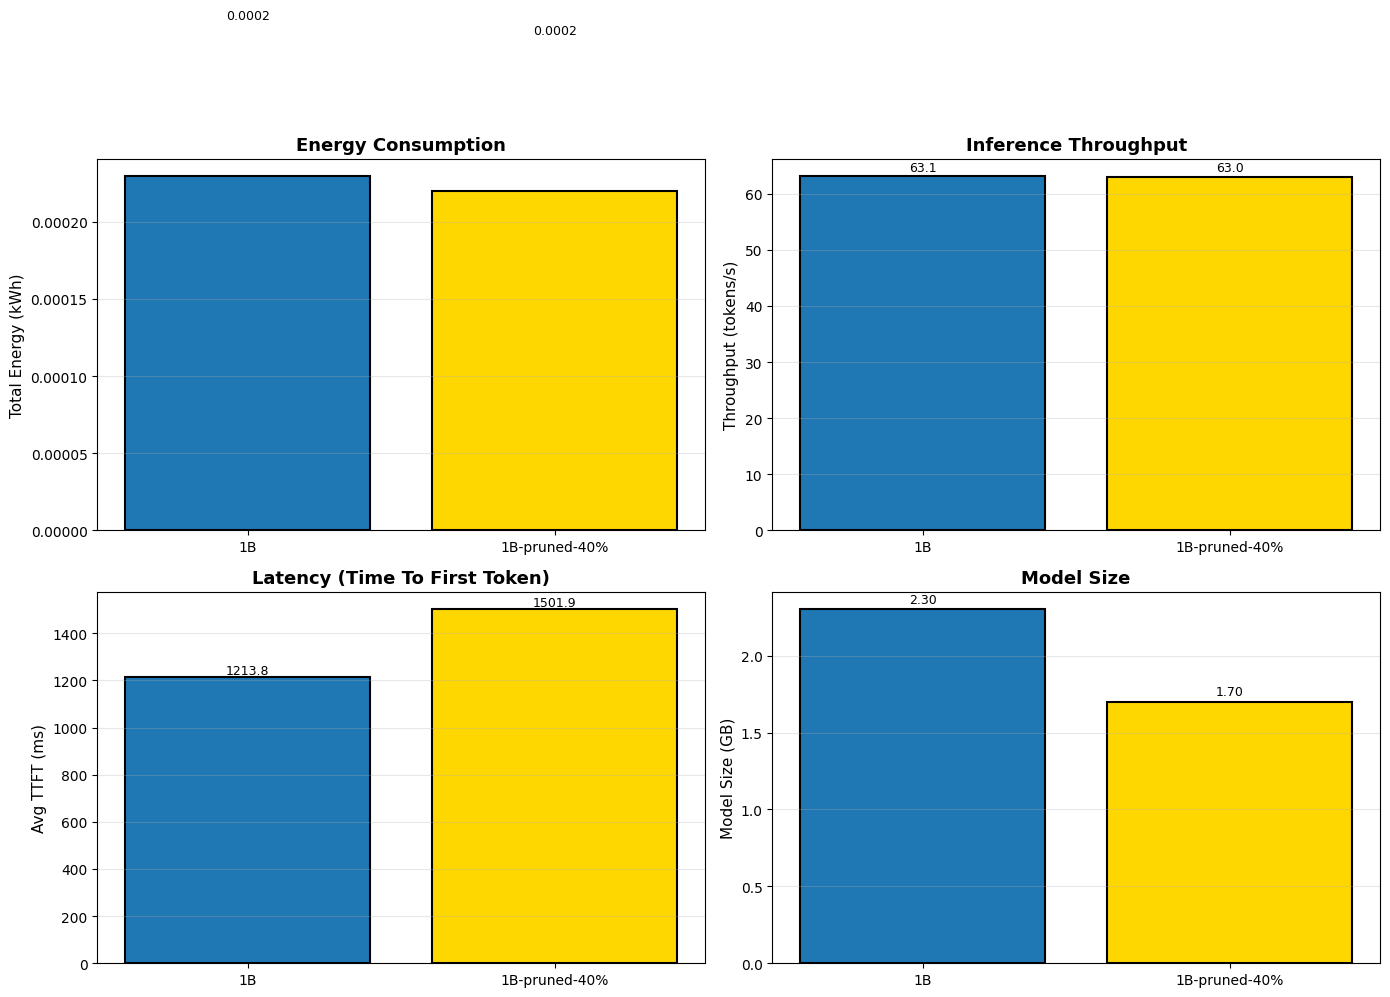


📊 Visualization saved to: /content/drive/MyDrive/glu_pruning/results/carbon_1b_analysis.png


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = summary_df['model'].values
pruning_levels = summary_df['pruning_pct'].values
star_mask = summary_df['is_star'].values

# Colors: baseline blue, star gold, others gray
colors = ['#1f77b4' if p == 0 else '#FFD700' if s else '#95a5a6'
          for p, s in zip(pruning_levels, star_mask)]

# 1. Energy Consumption
axes[0, 0].bar(range(len(models)), summary_df['total_energy_kwh'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 0].set_ylabel('Total Energy (kWh)', fontsize=11)
axes[0, 0].set_title('Energy Consumption', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['total_energy_kwh']):
    axes[0, 0].text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Throughput
axes[0, 1].bar(range(len(models)), summary_df['avg_throughput_tok_s'], color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_xticks(range(len(models)))
axes[0, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[0, 1].set_ylabel('Throughput (tokens/s)', fontsize=11)
axes[0, 1].set_title('Inference Throughput', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_throughput_tok_s']):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 3. Latency (TTFT)
axes[1, 0].bar(range(len(models)), summary_df['avg_ttft_ms'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 0].set_ylabel('Avg TTFT (ms)', fontsize=11)
axes[1, 0].set_title('Latency (Time To First Token)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['avg_ttft_ms']):
    axes[1, 0].text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# 4. Model Size
axes[1, 1].bar(range(len(models)), summary_df['model_size_gb'], color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_xticks(range(len(models)))
axes[1, 1].set_xticklabels([m.replace('Llama-3.2-', '') for m in models], rotation=0, ha='center')
axes[1, 1].set_ylabel('Model Size (GB)', fontsize=11)
axes[1, 1].set_title('Model Size', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(summary_df['model_size_gb']):
    axes[1, 1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/carbon_1b_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Visualization saved to: {RESULTS_DIR}/carbon_1b_analysis.png")

# 7. Decision Matrix: Which Models to Upload?

Based on the evaluation results, determine which models should be uploaded to HuggingFace Hub for Phase 2.

In [13]:
print(f"\n{'='*70}")
print("📊 CONSOLIDATING CARBON & PERFORMANCE RESULTS (DYNAMIC FILE-BASED)")
print(f"{'='*70}\n")

# --- Validar variables globales ---
# (Asegúrate de que estas variables estén definidas en celdas anteriores de tu notebook)
if 'CHECKPOINT_DIR' not in globals():
    print("⚠️ Warning: CHECKPOINT_DIR not set. Using default './checkpoints/1b_carbon'")
    CHECKPOINT_DIR = "/content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon"

if 'RESULTS_DIR' not in globals():
    print("⚠️ Warning: RESULTS_DIR not set. Using default './results'")
    RESULTS_DIR = "/content/drive/MyDrive/glu_pruning/results"

if 'BENCHMARKS_CARBON' not in globals():
    print("❌ Error: BENCHMARKS_CARBON not defined. Please import from utils.")
    # Fallback por si acaso
    BENCHMARKS_CARBON = [
        {"name": "gsm8k_workload", "num_prompts": 100, "max_new_tokens": 100, "dataset": "gsm8k"},
        {"name": "mmlu_workload", "num_prompts": 100, "max_new_tokens": 50, "dataset": "mmlu"},
        {"name": "ifeval_workload", "num_prompts": 100, "max_new_tokens": 150, "dataset": "IFEval"}
    ]

if 'EXPERIMENT_CONFIG_CARBON' not in globals():
     print("❌ Error: EXPERIMENT_CONFIG_CARBON not defined. Please import from utils.")
     # Fallback por si acaso
     EXPERIMENT_CONFIG_CARBON = [
        {"base_model": "meta-llama/Llama-3.2-1B", "pruning_pct": 0, "is_star": False},
        {"base_model": "meta-llama/Llama-3.2-1B", "pruning_pct": 40, "is_star": True},
     ]
# --- Fin de la validación ---


# --- Cargar datos de los checkpoints ---
print(f"Searching for carbon results in: {CHECKPOINT_DIR}")
json_files = glob.glob(f"{CHECKPOINT_DIR}/llama_3.2_1b_*_carbon.json")
print(f"Found {len(json_files)} individual result files to process.")

all_model_results = {}
hardware_info = {} # Para guardar la metadata de hardware

for json_path in sorted(json_files):
    print(f"  -> Processing: {os.path.basename(json_path)}")
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        model_name = data.get("metadata", {}).get("model_name", "Unknown")
        results = data.get("results", {})

        if not results:
            print(f"    ⚠️ Warning: No 'results' found in file. Skipping.")
            continue

        all_model_results[model_name] = results

        # Guardar la metadata de hardware (asumimos que es la misma, usamos la del baseline)
        if "baseline" in model_name and not hardware_info:
            first_workload = list(results.values())[0]
            if "hardware_metadata" in first_workload:
                hardware_info = first_workload["hardware_metadata"]
                print(f"    Captured hardware metadata (GPU: {hardware_info.get('gpu_model', 'N/A')})")

    except Exception as e:
        print(f"    ⚠️ Warning: Could not read or parse file. Error: {e}")
        continue
# --- Fin de la carga de datos ---


# --- Construir el JSON Completo ---

# 1. Construir mapeo de configuración
config_map = {}
model_family_name = "Llama-3.2-1B" # Hardcoded para este notebook

for cfg in EXPERIMENT_CONFIG_CARBON:
    if model_family_name not in cfg["base_model"]:
        continue

    pruning_pct = cfg['pruning_pct']
    key = "baseline" if pruning_pct == 0 else f"pruned_{pruning_pct}pct"

    # Construir el nombre que aparece en el display
    model_name = f"{model_family_name}" if pruning_pct == 0 else f"{model_family_name}-pruned-{pruning_pct}%"

    # Construir la clave REAL que se guarda en los JSON (debe coincidir con metadata.model_name)
    if pruning_pct == 0:
        internal_key = f"{model_family_name}-baseline"  # ← AJUSTAR SEGÚN TU FORMATO
    else:
        internal_key = f"{model_family_name}-pruned-{pruning_pct}%"

    hf_repo = cfg.get("hf_repo_id", cfg["base_model"]) if pruning_pct > 0 else cfg["base_model"]

    config_map[key] = {
        "name": model_name,
        "pruning_pct": int(pruning_pct),
        "is_star": bool(cfg["is_star"]),
        "hf_repo": hf_repo,
        "internal_key": internal_key  # ← AHORA USA EL FORMATO CORRECTO
    }

print(f"\nDynamically built config map for {len(config_map)} models.")

# 2. Construir 'models_evaluated'
models_evaluated = {}
summary_stats_list = []

for key, config in config_map.items():
    model_key_name = config["internal_key"]

    if model_key_name in all_model_results:
        # Los resultados de 'all_model_results' ya tienen el formato correcto (workload -> metrics)
        models_evaluated[key] = {
            "name": config["name"],
            "pruning_pct": config["pruning_pct"],
            "is_star": config["is_star"],
            "hf_repo": config["hf_repo"],
            "results": all_model_results[model_key_name]
        }

        # Calcular estadísticas de resumen para este modelo
        workload_results = all_model_results[model_key_name].values()
        summary_stats_list.append({
            "model": config["name"],
            "pruning_pct": config["pruning_pct"],
            "is_star": config["is_star"],
            "total_energy_kwh": sum(m.get('energy_kwh', 0) for m in workload_results),
            "avg_throughput_tok_s": np.mean([m.get('throughput_tokens_per_sec', 0) for m in workload_results]),
            "avg_ttft_ms": np.mean([m['avg_ttft_ms'] for m in workload_results if m.get('avg_ttft_ms') is not None]) if any(m.get('avg_ttft_ms') is not None for m in workload_results) else 0,
            "model_size_gb": list(workload_results)[0].get('model_size_gb', 0) # Tomar el primero
        })
    else:
        print(f"⚠️ Warning: No results found for model '{model_key_name}' in loaded checkpoints.")

# 3. Construir 'summary_statistics'
baseline_stats = next((s for s in summary_stats_list if s['pruning_pct'] == 0), None)
pruned_stats = [s for s in summary_stats_list if s['pruning_pct'] > 0]

summary_statistics = {
    "baseline": baseline_stats,
    "pruned_models": pruned_stats
}

# 4. Consolidar todo
complete_results = {
    "experiment_metadata": {
        "timestamp": datetime.now().isoformat(),
        "notebook": "03_Evaluate_1B_CARBON.ipynb",
        "model_family": model_family_name,
        "pruning_method": "MAW (Maximum Absolute Weight)",
        "hardware_details": hardware_info # <-- METADATA AÑADIDA
    },
    "benchmarks": [
        {
            "name": task["name"],
            "num_prompts": task["num_prompts"],
            "max_new_tokens": task["max_new_tokens"],
            "description": task["description"]
        }
        for task in BENCHMARKS_CARBON
    ],
    "models_evaluated": models_evaluated,
    "summary_statistics": summary_statistics,
    "citation": {
        "paper": "Exploring GLU Expansion Ratios: Structured Pruning in Llama-3.2 Models",
        "author": "Pere Martra",
        "doi": "https://doi.org/10.31219/osf.io/qgxea",
        "github": "https://github.com/peremartra/llama-glu-expansion-pruning",
        "note": "Results are freely available for research purposes. Please cite the paper if you use this data."
    }
}
print(f"Successfully consolidated results for {len(models_evaluated)} models.")

# --- Fin de la construcción del JSON ---


# --- Guardar en JSON ---
try:
    os.makedirs(RESULTS_DIR, exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    json_path = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_{timestamp}.json"
    with open(json_path, 'w') as f:
        json.dump(complete_results, f, indent=2, ensure_ascii=False)

    print(f"\n✅ Complete carbon results saved to:")
    print(f"   {json_path}")

    # Also save a "latest" version
    latest_json = f"{RESULTS_DIR}/llama_1b_carbon_complete_results_latest.json"
    with open(latest_json, 'w') as f:
        json.dump(complete_results, f, indent=2, ensure_ascii=False)

    print(f"✅ Latest version:")
    print(f"   {latest_json}")

    file_size_kb = Path(json_path).stat().st_size / 1024
    print(f"\n📊 File size: {file_size_kb:.1f} KB")

except Exception as e:
    print(f"❌ Error saving JSON files: {e}")
    print(f"   Please ensure RESULTS_DIR is defined and writeable: {RESULTS_DIR}")

print(f"\n📦 Models included: {len(complete_results['models_evaluated'])}")
print(f"📋 Benchmarks per model: {len(BENCHMARKS_CARBON)}")

print(f"\n{'='*70}")
print("✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing")
print(f"{'='*70}\n")


📊 CONSOLIDATING CARBON & PERFORMANCE RESULTS (DYNAMIC FILE-BASED)

Searching for carbon results in: /content/drive/MyDrive/glu_pruning/checkpoints/1b_carbon
Found 2 individual result files to process.
  -> Processing: llama_3.2_1b_baseline_carbon.json
    Captured hardware metadata (GPU: N/A)
  -> Processing: llama_3.2_1b_pruned_40pct_carbon.json

Dynamically built config map for 2 models.
Successfully consolidated results for 2 models.

✅ Complete carbon results saved to:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_20251105_230111.json
✅ Latest version:
   /content/drive/MyDrive/glu_pruning/results/llama_1b_carbon_complete_results_latest.json

📊 File size: 36.9 KB

📦 Models included: 2
📋 Benchmarks per model: 6

✅ COMPLETE CARBON RESULTS SAVED - Ready for research sharing



In [14]:
# Después de cargar los datos, agrega esto:
print(f"\n📋 Available model keys in loaded results:")
for key in all_model_results.keys():
    print(f"   - '{key}'")
print()


📋 Available model keys in loaded results:
   - 'Llama-3.2-1B-baseline'
   - 'Llama-3.2-1B-pruned-40%'



---

## 🎓 Key Takeaways

This notebook evaluated the Llama-3.2-1B model family across 10 comprehensive benchmarks to determine:

1. **Optimal pruning level** for GLU-MLP layers
2. **Performance-efficiency trade-offs** at different expansion ratios
3. **Which models justify upload** to HuggingFace Hub


---

**Powered by OptiPFair** - Structured Pruning for GLU Architectures

If this research helps your work:
- ⭐ Star [the repo](https://github.com/peremartra/optipfair)
- 📖 Read the [documentation](https://peremartra.github.io/optipfair/)
- 🐛 Report issues or suggest features

---